<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Catboost</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

# from tqdm.notebook import tqdm
from tqdm.auto import tqdm

## Data

In [2]:
df = pd.read_csv('../data/transactions_train.csv')

In [3]:
df = df.sort_values(['client_id', 'trans_date'])

In [4]:
y = pd.read_csv('../data/train_target.csv')

In [5]:
df = pd.merge(df, y, on='client_id')

In [6]:
print('before downsampling:\n', df.dtypes)
df['client_id'] = pd.to_numeric(df['client_id'], downcast='unsigned')
df['trans_date'] = pd.to_numeric(df['trans_date'], downcast='unsigned')
df['small_group'] = pd.to_numeric(df['small_group'], downcast='signed')
df['amount_rur'] = pd.to_numeric(df['amount_rur'], downcast='float')

print('after downsampling:\n',df.dtypes)

before downsampling:
 client_id        int64
trans_date       int64
small_group      int64
amount_rur     float64
bins             int64
dtype: object
after downsampling:
 client_id       uint16
trans_date      uint16
small_group      int16
amount_rur     float32
bins             int64
dtype: object


In [7]:
groups = pd.read_csv('../data/small_group_description.csv')

In [8]:
df['weekday'] = df['trans_date'] % 7

## EDA

Для сегментирования отдельных групп пользователей, провести кластеризацию пользователей и использовать метки получившихся классов в качестве предсказываемой переменной. Обученные эмбединги использовать для предсказания реальных данных(в нашей задаче это возрастные группы).

Кластеризация пользователей на основе handmade признаков обоснование выбора признаков с использованием EDA. Кластеризация пользователей любым способом, который кажется пригодным(с учетом особенностей данных). Визуализация категорий пользователей с использованием алгоритмов понижения размерности данных.

In [9]:
np.random.seed(228)

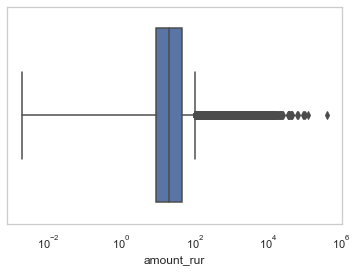

In [10]:
sns.boxplot(x=df['amount_rur'].sample(1000000))
plt.xscale('log')

In [11]:
tmp = df.groupby('small_group')[['amount_rur']].agg(['mean', 'count', 'max', 'min']).reset_index()
tmp.columns =['small_group_code', 'mean', 'count', 'max', 'min']
tmp = tmp.set_index('small_group_code')
tmp = tmp.join(groups, on='small_group_code', how='outer').reset_index(drop=True)
tmp = tmp.sort_values('count', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
1,41.666897,8131374.0,22447.980469,0.002000,Сетевые супермаркеты и продуктовые магазины,1
11,21.339022,3202881.0,11515.068359,0.001000,Фастфуд и кафе,11
3,19.819042,2428984.0,24261.560547,0.001000,Оплата телефона и связи,3
15,21.617123,1427077.0,13318.199219,0.005000,Несетевые супермаркеты и продуктовые магазины,15
4,34.616478,1207604.0,38081.308594,0.001000,Аптеки,4
...,...,...,...,...,...,...
198,45.794998,1.0,45.794998,45.794998,Услуги починки (металлические изделия),199
199,126.484001,1.0,126.484001,126.484001,Телеграф,200
201,68.968002,1.0,68.968002,68.968002,Бетонные работы,203
202,NaN,NaN,NaN,NaN,Снегоходы,194


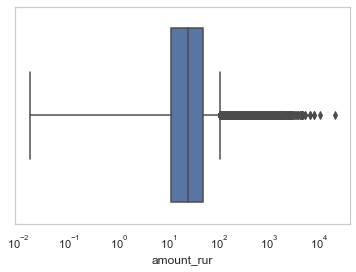

In [12]:
mask = df['small_group'] == 1
sns.boxplot(x=df[mask]['amount_rur'].sample(1000000))
plt.xscale('log')

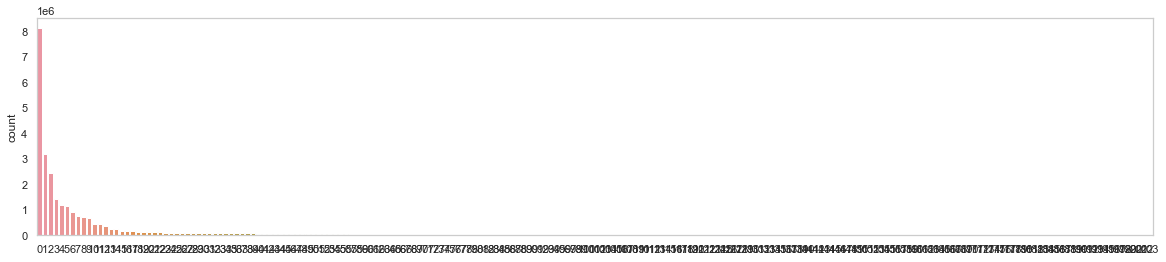

In [13]:
fig, axs = plt.subplots(figsize=(20, 4))

sns.barplot(x=list(range(len(tmp))), y=tmp['count'].sort_values(ascending=False));

In [14]:
quantiles = np.arange(0.1, 1.1, 0.1)
counts = [int(tmp['count'].quantile(i)) for i in quantiles]
quantiles = pd.DataFrame({'quantile': quantiles, 'count': counts})
quantiles

,quantile,count
0,0.1,34
1,0.2,183
2,0.3,516
3,0.4,1174
4,0.5,3287
5,0.6,11474
6,0.7,23829
7,0.8,61634
8,0.9,121845
9,1.0,8131374


In [15]:
tmp = tmp.sort_values('mean', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
173,1352.014282,100.0,9793.549805,0.824,Металлопрокат,173
170,1344.033936,209.0,7440.359863,1.294,Окна и двери,170
181,1275.825684,73.0,16371.612305,0.190,Прочие отели (аппартаменты),181
178,1187.892944,38.0,13553.929688,3.450,Камины и печи,178
190,1180.543213,28.0,9159.056641,4.579,Услуги починки (кондиционеры и холодильники),190
...,...,...,...,...,...,...
115,17.517340,19657.0,2426.331055,0.043,"Видео (онлайн-кинотеатры, онлайн-каналы, видео...",115
47,14.888980,37602.0,1831.812012,0.043,Пекарня,47
196,12.542286,7.0,29.863001,4.313,Ортопедия,197
202,NaN,NaN,NaN,NaN,Снегоходы,194


In [16]:
tmp = tmp.sort_values('max', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
36,77.394745,372445.0,400086.781250,0.004000,Косметика,36
80,391.396545,45405.0,319685.687500,0.043000,Аксессуары (драгоценности и часы),80
24,197.395203,462932.0,291837.218750,0.002000,Одежда,24
14,800.021484,28905.0,284318.687500,0.014000,Автодилеры и автосервис,14
21,221.938492,121548.0,219405.437500,0.009000,Больницы и поликлинники,21
...,...,...,...,...,...,...
201,68.968002,1.0,68.968002,68.968002,Бетонные работы,203
198,45.794998,1.0,45.794998,45.794998,Услуги починки (металлические изделия),199
196,12.542286,7.0,29.863001,4.313000,Ортопедия,197
202,NaN,NaN,NaN,NaN,Снегоходы,194


In [17]:
tmp = tmp.sort_values('min', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
188,167.153000,1.0,167.153000,167.153000,Остеопаты,188
192,394.421753,4.0,800.364990,151.929993,Аренда оборудования для грузовиков и трейлеров,192
199,126.484001,1.0,126.484001,126.484001,Телеграф,200
201,68.968002,1.0,68.968002,68.968002,Бетонные работы,203
200,72.919502,2.0,93.788002,52.050999,Скорая помощь,202
...,...,...,...,...,...,...
74,39.743542,17072.0,25286.824219,0.001000,Благотворительность и краудфандинг,74
66,308.694061,10944.0,9001.336914,0.001000,Мужская одежда,66
53,143.307175,30098.0,35205.031250,0.001000,Оплата налогов,53
202,NaN,NaN,NaN,NaN,Снегоходы,194


**drop transactions from categories with low number of samples**

keep transactions from categories > 0.7 quantile

In [18]:
df = df[df['small_group'].isin(set(tmp[tmp['count'] > 23829]['small_group_code']))]

## Feature engineering

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import gc

**maybe not needed**

In [20]:
oh_enc = OneHotEncoder(handle_unknown='ignore')
oh_enc.fit(tmp[tmp['count'] > 23829]['small_group_code'].to_numpy().reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore')

In [21]:
oh_groups = oh_enc.transform(df['small_group'].to_numpy().reshape(-1, 1)).toarray()

In [22]:
oh_groups = oh_groups.astype(np.uint8)

In [23]:
cols = list(df.columns) + list(range(oh_groups.shape[1]))
df = pd.DataFrame(np.column_stack([df, oh_groups]), columns=cols)

In [24]:
del oh_groups
gc.collect()

90

In [25]:
df.head()

,client_id,trans_date,small_group,amount_rur,bins,weekday,0,1,2,3,...,51,52,53,54,55,56,57,58,59,60
0,4.0,0.0,1.0,10.209000,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,2.0,3.0,27.705999,1.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,3.0,1.0,13.024000,1.0,3.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,4.0,1.0,17.632000,1.0,4.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,6.0,4.0,18.089001,1.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
group_codes = list(range(61))

In [56]:
client_df = df.groupby('client_id')[group_codes].sum()

In [57]:
client_df.columns = [f'group_cnt_{i}' for i in group_codes]

https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns

In [58]:
tmp = df.groupby(['client_id', 'weekday'])[group_codes].sum().reset_index()

In [59]:
tmp = tmp.pivot(index='client_id', columns='weekday', values=group_codes)

In [62]:
tmp.columns = [f'group_cnt_{c1}_weekday_{c2:.0f}' for c1, c2 in tmp.columns.values]

In [66]:
client_df = client_df.join(tmp)

In [76]:
tmp = df.groupby(['client_id', 'small_group'])[['amount_rur']].mean().reset_index()
tmp = tmp.pivot(index='client_id', columns='small_group', values='amount_rur')
tmp = tmp.fillna(0)

In [77]:
tmp.columns = [f'group_mean_{i}' for i in range(61)]

In [78]:
client_df = client_df.join(tmp)

In [94]:
client_df = client_df.join(y.set_index('client_id'))

## Catboost

In [111]:
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [95]:
X = client_df.drop('bins', axis=1)
y = client_df['bins']

In [99]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, shuffle=False)

In [104]:
logit = LogisticRegression(multi_class='ovr', random_state=228, solver='liblinear')
logit.fit(X_train, y_train)

/Users/th/Documents/hse_embeddings/env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [117]:
logit_train_pred = logit.predict_proba(X_train)
logit_valid_pred = logit.predict_proba(X_valid)

logit_train_pred = logit.predict(X_train)
logit_valid_pred = logit.predict(X_valid)

In [119]:
logit_valid_pred.max()

3

In [122]:
print(metrics.classification_report(y_valid, logit.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.49      0.37      0.42      2255
           1       0.60      0.73      0.66      2229
           2       0.66      0.79      0.72      2293
           3       0.48      0.39      0.43      2223

    accuracy                           0.57      9000
   macro avg       0.56      0.57      0.56      9000
weighted avg       0.56      0.57      0.56      9000



In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

metrics.plot_confusion_matrix(
    logit, X_valid, y_valid,
    display_labels=df.bins, ax = ax)

to try

count num transactions in each category (count vectorizer)

count avg by customer in each category

max in each category

min in each category

averages by weekday